In [1]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns

import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
df = pd.read_csv("Kindle_Reviews_Cleaned.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,unixReviewTime,reviewText_punctuation,reviewText_stopwords,reviewText_tokenized,reviewText_lemmatized
0,0,0,B000F83SZQ,"[0, 0]",5,i enjoy vintage books and movies so i enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,1399248000,i enjoy vintage books and movies so i enjoyed ...,enjoy vintage books movies enjoyed reading boo...,"['enjoy', 'vintage', 'books', 'movies', 'enjoy...","['enjoy', 'vintage', 'book', 'movie', 'enjoyed..."
1,1,1,B000F83SZQ,"[2, 2]",4,this book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,1388966400,this book is a reissue of an old one the autho...,book reissue old one author born 1910 era say ...,"['book', 'reissue', 'old', 'one', 'author', 'b...","['book', 'reissue', 'old', 'one', 'author', 'b..."
2,2,2,B000F83SZQ,"[2, 2]",4,this was a fairly interesting read. it had old...,"04 4, 2014",A795DMNCJILA6,dot,1396569600,this was a fairly interesting read it had old ...,fairly interesting read old style terminologyi...,"['fairly', 'interesting', 'read', 'old', 'styl...","['fairly', 'interesting', 'read', 'old', 'styl..."
3,3,3,B000F83SZQ,"[1, 1]",5,i'd never read any of the amy brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",1392768000,id never read any of the amy brewster mysterie...,id never read amy brewster mysteries one reall...,"['id', 'never', 'read', 'amy', 'brewster', 'my...","['id', 'never', 'read', 'amy', 'brewster', 'my..."
4,4,4,B000F83SZQ,"[0, 1]",4,"if you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,1395187200,if you like period pieces clothing lingo you ...,like period pieces clothing lingo enjoy myster...,"['like', 'period', 'pieces', 'clothing', 'ling...","['like', 'period', 'piece', 'clothing', 'lingo..."


In [3]:
#make column about rating
#Adding the sentiments column (rating of 1,2,3 is negative (represented by 0))
df['sentiments'] = df.overall.apply(lambda x: 0 if x in [1, 2, 3] else 1)

In [4]:
#"taking one fourth data so we can run on our machine easily"
#make a smaller sample
np.random.seed(34)
dfsample = df.sample(frac = 0.25)

In [5]:
dfsample.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'asin', 'helpful', 'overall',
       'reviewText', 'reviewTime', 'reviewerID', 'reviewerName',
       'unixReviewTime', 'reviewText_punctuation', 'reviewText_stopwords',
       'reviewText_tokenized', 'reviewText_lemmatized', 'sentiments'],
      dtype='object')

In [6]:
dfsample. shape

(245655, 15)

In [7]:
dfsample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245655 entries, 932513 to 140838
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Unnamed: 0              245655 non-null  int64 
 1   Unnamed: 0.1            245655 non-null  int64 
 2   asin                    245655 non-null  object
 3   helpful                 245655 non-null  object
 4   overall                 245655 non-null  int64 
 5   reviewText              245649 non-null  object
 6   reviewTime              245655 non-null  object
 7   reviewerID              245655 non-null  object
 8   reviewerName            244693 non-null  object
 9   unixReviewTime          245655 non-null  int64 
 10  reviewText_punctuation  245649 non-null  object
 11  reviewText_stopwords    245649 non-null  object
 12  reviewText_tokenized    245655 non-null  object
 13  reviewText_lemmatized   245655 non-null  object
 14  sentiments              245655 

In [8]:
dfsample.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
asin                      object
helpful                   object
overall                    int64
reviewText                object
reviewTime                object
reviewerID                object
reviewerName              object
unixReviewTime             int64
reviewText_punctuation    object
reviewText_stopwords      object
reviewText_tokenized      object
reviewText_lemmatized     object
sentiments                 int64
dtype: object

In [9]:
np.sum(dfsample.isnull().any(axis=1))

968

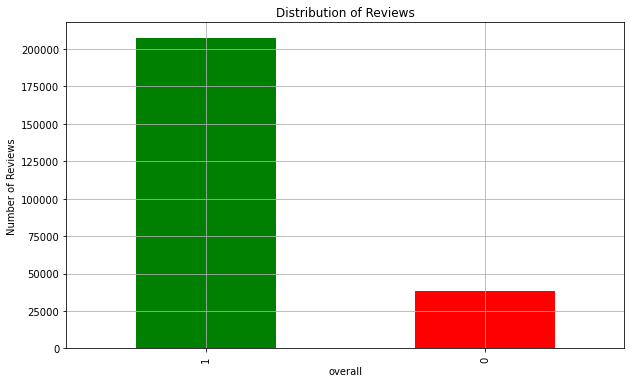

In [10]:
category_dist = dfsample['sentiments'].value_counts()

plt.figure(figsize=(10,6))
my_colors = ['g', 'r']
category_dist.plot(kind='bar', color=my_colors)
plt.grid()
plt.xlabel("overall")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Reviews")
plt.show()

In [11]:
positives = dfsample[dfsample['sentiments'] == 1]
negatives = dfsample[dfsample['sentiments'] == 0]

In [12]:
negatives.count

<bound method DataFrame.count of         Unnamed: 0  Unnamed: 0.1        asin  helpful  overall  \
932513      932513        932513  B00KCS1EUA   [1, 1]        3   
551150      551150        551150  B00DDD8L6G   [0, 0]        3   
28744        28744         28744  B0044DF5KO   [0, 0]        3   
193861      193861        193861  B007KKW9GQ   [0, 0]        3   
308371      308371        308371  B009ED2BJ2   [1, 2]        3   
...            ...           ...         ...      ...      ...   
249096      249096        249096  B008DS35CQ   [0, 0]        3   
33015        33015         33015  B004AYDGVM  [5, 11]        2   
629903      629903        629903  B00ET7Q4OG   [0, 0]        3   
417788      417788        417788  B00B7N2ECG   [0, 1]        2   
770782      770782        770782  B00HHLH8Z0   [0, 0]        3   

                                               reviewText   reviewTime  \
932513  3.5 starsthis short story is the start of a ne...  06 28, 2014   
551150  an ok read. liked 

In [13]:
positives.count

<bound method DataFrame.count of         Unnamed: 0  Unnamed: 0.1        asin helpful  overall  \
398184      398184        398184  B00AWGED8W  [2, 4]        5   
611335      611335        611335  B00EDYFZVS  [0, 0]        4   
978601      978601        978601  B00LLXRJR2  [1, 1]        5   
695138      695138        695138  B00G4LJE74  [0, 0]        5   
296787      296787        296787  B0095VONZS  [0, 0]        4   
...            ...           ...         ...     ...      ...   
868956      868956        868956  B00J47HAUS  [0, 0]        4   
243693      243693        243693  B008AP8VS0  [0, 2]        5   
947574      947574        947574  B00KOG0B8Q  [4, 4]        5   
20977        20977         20977  B003U4WB7I  [2, 2]        5   
140838      140838        140838  B006ETE7X2  [1, 1]        4   

                                               reviewText   reviewTime  \
398184  i couldn't get enough of colin mitchell, a col...  04 21, 2014   
611335  i read this after i read the f

In [18]:
g = dfsample.groupby('sentiments')
g.apply(lambda x: x.sample(g.size().min()))

Unnamed: 0  Unnamed: 0.1        asin helpful  overall  \
sentiments                                                                 
0          159364      159364        159364  B006RDFDAQ  [0, 0]        3   
           96943        96943         96943  B005G51MDI  [3, 6]        1   
           341783      341783        341783  B009ZZVRMG  [0, 0]        3   
           682403      682403        682403  B00FUANYH6  [0, 1]        2   
           870422      870422        870422  B00J5DWTJ8  [1, 1]        1   
...                       ...           ...         ...     ...      ...   
1          477106      477106        477106  B00C2REABO  [0, 0]        5   
           858254      858254        858254  B00IX9I1WE  [1, 1]        5   
           814976      814976        814976  B00I7WFJHC  [1, 2]        5   
           433329      433329        433329  B00BFQ79ZC  [0, 0]        4   
           467919      467919        467919  B00BW9RJS4  [0, 0]        5   

                                                          reviewText  \
sentiments                                                             
0          159364  3 out of 5 stars! this novella is spicy and sw...   
           96943   would you remember me? this is the question as...   
           341783  the author has written a limited audience appe...   
           682403  i just don't like the side character treated a...   
           870422  violet, works at the library, reads poetry and...   
...                                                              ...   
1          477106  this book was alright it didn't end like i tho...   
           858254  the waitress help her and the little sister ! ...   
           814976  i really liked the way this book is written. i...   
           433329  great stories!loved both story lines and were ...   
           467919  i read all the money making mamas and i love t...   

                    reviewTime      reviewerID  \
sentiments                                       
0          159364   03 4, 2012   AJVQTGMBF8PL1   
           96943   03 17, 2012   AIO247KHD2O40   
           341783  09 14, 2013  A2L9TUOE290MT4   
           682403  03 21, 2014  A2VHUAB7SS8PCQ   
           870422  05 29, 2014  A1FHYFX244DREE   
...                        ...             ...   
1          477106  09 13, 2013  A1Q0PTHF31VLBU   
           858254  05 11, 2014  A278YO6V8SEBSA   
           814976  02 14, 2014  A3BQI23E5FQP7I   
           433329   07 2, 2013   ASHX33A1334SS   
           467919  03 28, 2013  A1FIX7316UNTX1   

                                             reviewerName  unixReviewTime  \
sentiments                                                                  
0          159364  Jess @ From Me to You ... Book Reviews      1330819200   
           96943                          James N Simpson      1331942400   
           341783                          Bill Thibadeau      1379116800   
           682403                              LiveInHoth      1395360000   
           870422                   Michelle Lynn Randall      1401321600   
...                                                   ...             ...   
1          477106                                  Neisha      1379030400   
           858254                          Jennie "sissy"      1399766400   
           814976                                  Jeanie      1392336000   
           433329                                Janie_tx      1372723200   
           467919                            Bria Roberts      1364428800   

                                              reviewText_punctuation  \
sentiments                                                             
0          159364  3 out of 5 stars this novella is spicy and swe...   
           96943   would you remember me this is the question ask...   
           341783  the author has written a limited audience appe...   
           682403  i just dont like the side character treated as...   
        

In [19]:
positives.count

<bound method DataFrame.count of         Unnamed: 0  Unnamed: 0.1        asin helpful  overall  \
398184      398184        398184  B00AWGED8W  [2, 4]        5   
611335      611335        611335  B00EDYFZVS  [0, 0]        4   
978601      978601        978601  B00LLXRJR2  [1, 1]        5   
695138      695138        695138  B00G4LJE74  [0, 0]        5   
296787      296787        296787  B0095VONZS  [0, 0]        4   
...            ...           ...         ...     ...      ...   
170431      170431        170431  B0071NP2D4  [0, 0]        5   
188274      188274        188274  B007GSO4XS  [0, 0]        5   
829862      829862        829862  B00IGCTI4I  [1, 2]        5   
361132      361132        361132  B00AD9J414  [4, 4]        4   
172443      172443        172443  B0073H86H2  [0, 0]        5   

                                               reviewText   reviewTime  \
398184  i couldn't get enough of colin mitchell, a col...  04 21, 2014   
611335  i read this after i read the f

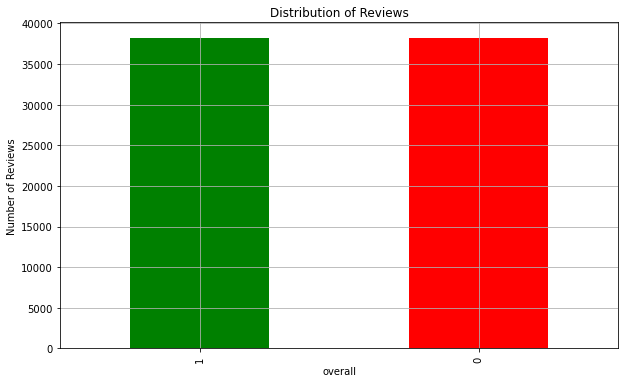

In [20]:
category_dist = dfsample['sentiments'].value_counts()

plt.figure(figsize=(10,6))
my_colors = ['g', 'r']
category_dist.plot(kind='bar', color=my_colors)
plt.grid()
plt.xlabel("overall")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Reviews")
plt.show()

In [21]:
dfsample.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
asin                      object
helpful                   object
overall                    int64
reviewText                object
reviewTime                object
reviewerID                object
reviewerName              object
unixReviewTime             int64
reviewText_punctuation    object
reviewText_stopwords      object
reviewText_tokenized      object
reviewText_lemmatized     object
sentiments                 int64
dtype: object

In [22]:
#Separating input feature and label
X = dfsample['reviewText_lemmatized']
y = dfsample['sentiments']

In [23]:
# Separating the 85% data for training data and 15% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15, random_state =26105111)

In [24]:
#Transforming Dataset using TF-IDF Vectorizer

In [25]:
#Fit the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

No. of feature_words:  500000


In [26]:
#Transform the data using TF-IDF Vectorizer
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [27]:
#Function For Model Evaluation (Accuracy Score, Confusion Matrix with Plot, ROC-AUC Curve)
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [28]:
#Model Building
#Bernoulli Naive Bayes, SVM (Support Vector Machine), Logistic Regression

In [29]:
#Model 1

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      5703
           1       0.85      0.86      0.86      5765

    accuracy                           0.86     11468
   macro avg       0.86      0.86      0.86     11468
weighted avg       0.86      0.86      0.86     11468



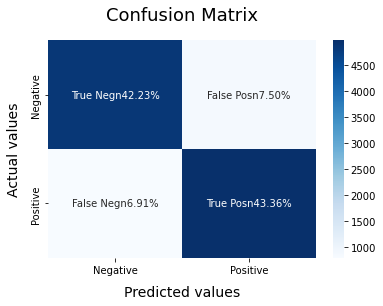

In [30]:
#Bernoulli
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

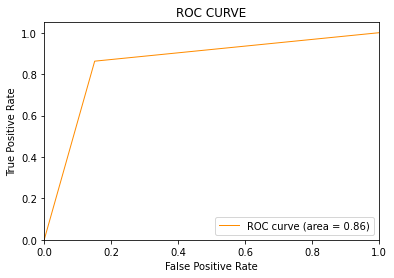

In [31]:
#Plot the ROC-AUC Curve for Bernoulli Naive Bayes Model
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [32]:
#Model 2

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5703
           1       0.85      0.86      0.86      5765

    accuracy                           0.85     11468
   macro avg       0.85      0.85      0.85     11468
weighted avg       0.85      0.85      0.85     11468



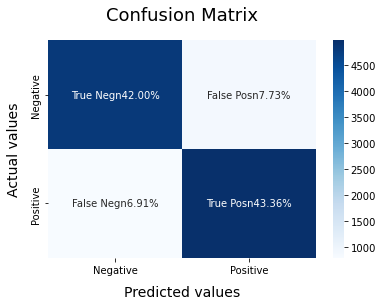

In [33]:
#SVC
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

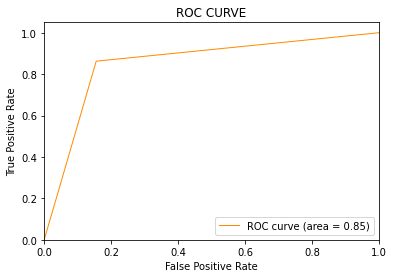

In [34]:
#Plot the ROC-AUC Curve for SVM (Support Vector Machine) Model
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [35]:
#Model 3

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5703
           1       0.86      0.87      0.86      5765

    accuracy                           0.86     11468
   macro avg       0.86      0.86      0.86     11468
weighted avg       0.86      0.86      0.86     11468



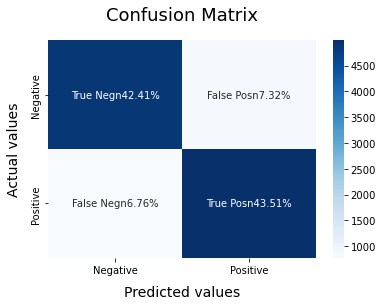

In [36]:
#Logistic Regression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

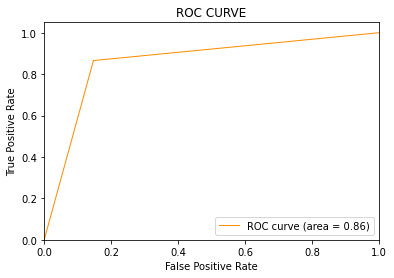

In [37]:
#Plot the ROC-AUC Curve for Logistic Regression Model
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()